## Initial setup

In [5]:
import pandas as pd
import numpy as np
from chardet import detect
import matplotlib.pyplot as plt
import seaborn as sns
import os
import importlib.util
import subprocess

In [2]:
# Defining default visualisation settings
sns.set_theme(palette='inferno')
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
#Configuring LLM for later result interpretations
if 'OPENAI_API_KEY' in os.environ:
    api_key = os.environ['OPENAI_API_KEY']
    from openai import OpenAI
    model,role = "gpt-3.5-turbo","user"
    client = OpenAI(api_key = api_key)
else:
    api_key = None

### Preparing the data

In [9]:
def check_encoding(file: str = None)-> str:
    with open(file, 'rb') as f:
        encoding = detect(f.read(10000))['encoding']
        return encoding

def load_apartments_data():
    """
    Checks if the file 'apartment_data.csv' exists in the current working directory.
    If not, fetches data using ucimlrepo, saves it as a CSV file, and loads it into a DataFrame.
    Returns a DataFrame `apartments_source`.
    """
    file_name = "apartment_data.csv"

    # Check if the ucimlrepo package is installed
    if importlib.util.find_spec("ucimlrepo") is None:
        print("The 'ucimlrepo' package is not installed. Installing it now...")
        subprocess.check_call(["pip", "install", "ucimlrepo"])
        print("Installation complete.")

    if not os.path.exists(file_name):
        print(f"The file '{file_name}' does not exist. Fetching data...")
        # Install ucimlrepo (requires an internet connection)
        try:
            import ucimlrepo
        except ImportError:
            os.system("pip install ucimlrepo")
            from ucimlrepo import fetch_ucirepo
        # Fetching data from the UC Irvine repository
        from ucimlrepo import fetch_ucirepo
        apartment_for_rent_classified = fetch_ucirepo(id=555)

        # Preparing the data
        X = apartment_for_rent_classified.data.features
        y = apartment_for_rent_classified.data.targets

        # Combining features and targets into one DataFrame
        apartments_source = pd.concat([X, y], axis=1)

        # Saving to CSV
        apartments_source.to_csv(file_name, index=False)
        print(f"Data has been fetched and saved to the file '{file_name}'.")
    else:
        print(f"The file '{file_name}' already exists. Loading data...")

    # Loading data into a DataFrame
    apartments_source = pd.read_csv(source, encoding=check_encoding(source),low_memory=False,
                                    encoding_errors = 'ignore',
                                    delimiter=',')
    return apartments_source

# Example usage
apartments_source = load_apartments_data()


The file 'apartment_data.csv' already exists. Loading data...


In [11]:
#Leaving original data aside
apartments = apartments_source.copy()

## Data exploration

In [12]:
#Exploring basic properties of the dataframe
def describe_df(df: pd.DataFrame)-> None:
    """
    Given a dataframe, the function calls some most popular data exploration functions at once.
    :param df: 
    :return: None 
    """
    describe_functions = [(lambda df: df.head(5), "Head(5):"),
        (pd.DataFrame.describe, "Describe:"),
        (pd.DataFrame.info, "Info:"),
        (lambda df: df.isnull().sum()[df.isnull().sum() > 0],"Null values:")]
    
    for func,name in describe_functions:
        print(f"\n Applying function: {name}",end = "\n")
        print(func(df))
        
describe_df(apartments)


 Applying function: Head(5):
                 category                            title  \
0  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  housing/rent/apartment      Three BR 146 Lochview Drive   
2  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  housing/rent/apartment            Two BR 209 Aegean Way   
4  housing/rent/apartment         One BR 4805 Marquette NE   

                                                body amenities bathrooms  \
0  This unit is located at 507 & 509 Esplanade, R...       NaN         1   
1  This unit is located at 146 Lochview Drive, Ne...       NaN       1.5   
2  This unit is located at 3101 Morningside Drive...       NaN         2   
3  This unit is located at 209 Aegean Way, Vacavi...       NaN         1   
4  This unit is located at 4805 Marquette NE, Alb...       NaN         1   

  bedrooms currency fee  has_photo pets_allowed  ...  price_display  \
0        1      USD  No  Thumbnail         Cats  ...           2195  

In [14]:
#Removing unnecessary columns
apartments.drop(columns=['category','title','body','has_photo','source','time','price_display','currency','cityname','price_type'], inplace=True)
#Proper formatting of the columns
apartments.columns = apartments.columns.str.capitalize()
#Dropping duplicates
apartments.drop_duplicates(inplace=True)

In [34]:
#Converting numerical columns to float from objects
apartments = apartments.astype({'Bathrooms':float,"Bedrooms":float,"Square_feet":float})
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90610 entries, 0 to 90609
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Amenities     90610 non-null  object 
 1   Bathrooms     90610 non-null  float64
 2   Bedrooms      90610 non-null  float64
 3   Fee           90610 non-null  object 
 4   Pets_allowed  90610 non-null  object 
 5   Price         90610 non-null  float64
 6   Square_feet   90610 non-null  float64
 7   Latitude      90610 non-null  float64
 8   Longitude     90610 non-null  float64
 9   State_y       90610 non-null  object 
 10  Population    90610 non-null  float64
 11  Division      90610 non-null  object 
 12  Region        90610 non-null  object 
dtypes: float64(7), object(6)
memory usage: 9.0+ MB


In [9]:
#Changing all object types to string
#apartments = apartments.astype({col: 'string' for col in apartments.select_dtypes(include='object').columns})
#Limiting the dataset, cutting values under 5th percentile and over 95th percentile as there are outliers
#apartments = apartments[apartments['Square_feet'] <= apartments['Square_feet'].quantile(0.99)]
#apartments = apartments[apartments['Square_feet'] >= apartments['Square_feet'].quantile(0.01)]
#save_fig("attribute_histogram_plots")  # extra code

In [15]:
#Handling nulls: there are lots of empty values for pets and amenities, so I leave them in the model, but only small amount of other missing values, so I drop the other features
apartments['Pets_allowed'] = apartments['Pets_allowed'].fillna('Unknown')
apartments['Amenities'] = apartments['Amenities'].fillna('None')
apartments.dropna(subset=['Bathrooms','Bedrooms','Price','Latitude','Longitude','State'],inplace=True)
apartments.drop('Address',axis=1,inplace=True)

In [16]:
#% of records left from the original df
(apartments.shape[0]/apartments_source.shape[0]).__format__(".2f")

'0.91'

##### Removing 'state' and replacing it with 'population' to easier handle the categorical values. Getting the population data and state full names from onlines sources.

In [17]:
#Loading a table containing US division into regions
US_states_source = "US_states.csv"
US_states = pd.read_csv(US_states_source,encoding=check_encoding(US_states_source),delimiter=";")
# Assuming your DataFrame is named US_states
US_states.loc[US_states['State'] == 'Washington, D.C.', 'State'] = 'District of Columbia'

In [18]:
US_states

,State,Division,Region
0,Connecticut,New England,Northeast
1,Maine,New England,Northeast
2,Massachusetts,New England,Northeast
3,New Hampshire,New England,Northeast
4,Rhode Island,New England,Northeast
5,Vermont,New England,Northeast
6,New Jersey,Middle Atlantic,Northeast
7,New York,Middle Atlantic,Northeast
8,Pennsylvania,Middle Atlantic,Northeast
9,Maryland,Middle Atlantic,Northeast


In [19]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population" #data of US population by states
url2 = "https://www.bu.edu/brand/guidelines/editorial-style/us-state-abbreviations/" #table of the states' abbreviatons
# Extract all tables from the page
tables = pd.read_html(url)
# Reading the table containing population data for each state
state_population = tables[0]
state_population = state_population[[('State or territory','State or territory'),('Census population[8][a]','July 1, 2023 (est.)')]] 
state_population.columns = state_population.columns.get_level_values(1) #the table is a multindex one, reading only column values from level 1
state_population.rename(columns = {'July 1, 2023 (est.)':'Population','State or territory':'State'},inplace=True)
#Creating table with US states full names and abbreviations
abbr_table = pd.read_html(url2,header=0)[0]
abbr_table.rename(columns = {'Full Name':'State',"2-letter USPS":"Code"},inplace=True)

C:\Users\Michau\AppData\Local\Temp\ipykernel_13716\2799498114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_population.rename(columns = {'July 1, 2023 (est.)':'Population','State or territory':'State'},inplace=True)


In [20]:
#Finally merging the tables to gain data of population in the original table
state_population = state_population.merge(abbr_table,on = 'State',how = 'left').merge(US_states,on = "State", how = 'left' )
state_population.dropna(subset = 'Code', inplace = True)
state_population.drop(columns = 'Traditional Abbreviation',inplace = True)
apartments = apartments.merge(state_population,left_on = 'State',right_on = 'Code',how = 'left')
apartments.drop(columns = ['State_x','Code'],inplace = True)

In [21]:
apartments.head(3)

,Amenities,Bathrooms,Bedrooms,Fee,Pets_allowed,Price,Square_feet,Latitude,Longitude,State_y,Population,Division,Region
0,None,1,1,No,Cats,2195.0,542,33.8520,-118.3759,California,38965193.0,Pacific,West
1,None,1.5,3,No,"Cats,Dogs",1250.0,1500,37.0867,-76.4941,Virginia,8715698.0,South Atlantic,South
2,None,2,3,No,Unknown,1395.0,1650,35.8230,-78.6438,North Carolina,10835491.0,South Atlantic,South


In [24]:
import plotly.express as px

fig = px.treemap(
    apartments.assign(LogPopulation=np.log(apartments['Population'])),
    path=['Region', 'Division', 'State_y'],  # hierarchy
    values='LogPopulation',  # base for size of the rectangles
    color='Population',
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        'Region': 'Region',
        'Division': 'Division',
        'State_y': 'State',
        'Population': 'Population'
    },
    title="Interactive treemap of US regions,divisions and states"
)
fig.update_layout(
    width=1300,
    height=600)
fig.update_layout(
    showlegend=False,
    annotations=[
        dict(
            x=0.01,
            y=-0.05,
            text="Division adopted after US Census Bureau",
            showarrow=False,
            font=dict(size=10, color="white"),
            align="left")])
fig.show()

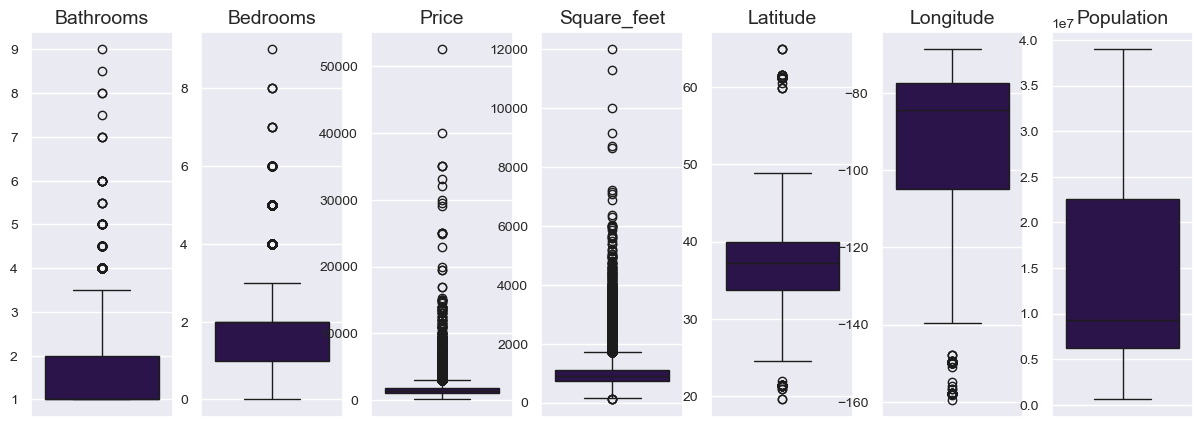

In [35]:
# Box plots of all the features
num_apartments = apartments.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=1, ncols=len(num_apartments.columns), figsize=(15, 5), sharey=False)

for i, column in enumerate(num_apartments.columns):
    sns.boxplot(data=num_apartments, y=column, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel("") 
plt.show()

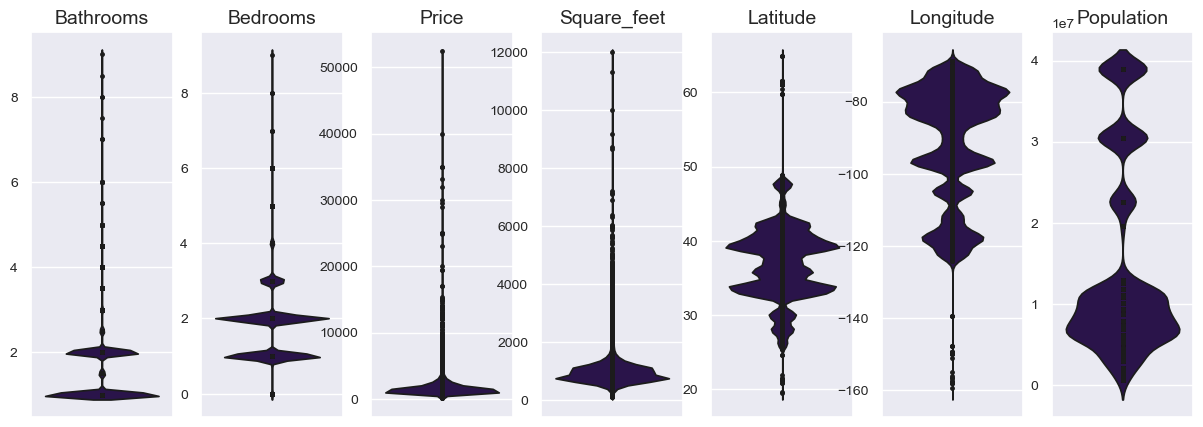

In [36]:
# Violin plots
num_apartments = apartments.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=1, ncols=len(num_apartments.columns), figsize=(15, 5), sharey=False)
for i, column in enumerate(num_apartments.columns):
    sns.violinplot(data=num_apartments, y=column, ax=axes[i], inner="point")
    axes[i].set_title(column)
    axes[i].set_ylabel("")
plt.show()

In [38]:
#Checking the proportions of values in Bedrooms and States
bedrooms_ratios = apartments['Bedrooms'].value_counts()/apartments.shape[0]*100
bedrooms_ratios.sort_index(inplace=True,ascending=True)
states_ratios = apartments['State_y'].value_counts()/apartments.shape[0]*100
regions_ratios = apartments['Region'].value_counts()/apartments.shape[0]*100
print(regions_ratios)

Region
South        43.108928
West         25.898907
Northeast    18.518927
Midwest      12.473237
Name: count, dtype: float64


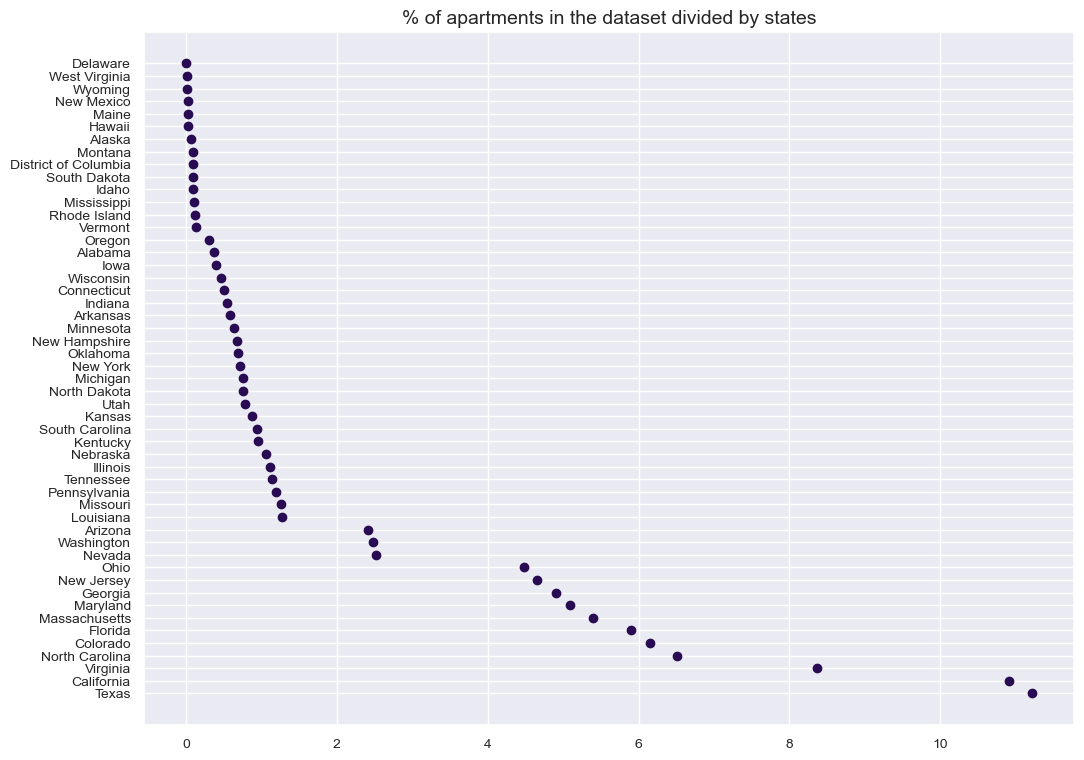

In [39]:
#Visualising
plt.figure(figsize=(12,9))
plt.scatter(states_ratios,
    states_ratios.index)
plt.title('% of apartments in the dataset divided by states')
plt.show()
    

<AxesSubplot:title={'center':'% of apartments divided by number of bedrooms'}, xlabel='Bedrooms'>

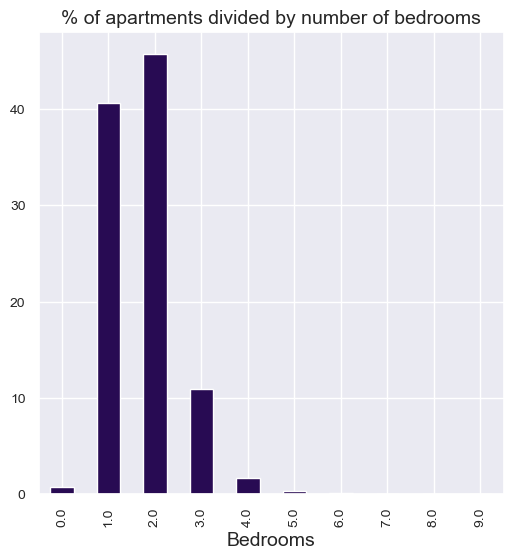

In [40]:
bedrooms_ratios.plot(kind='bar', stacked=False, figsize=(6, 6),title="% of apartments divided by number of bedrooms")


Text(0, 0.5, '')

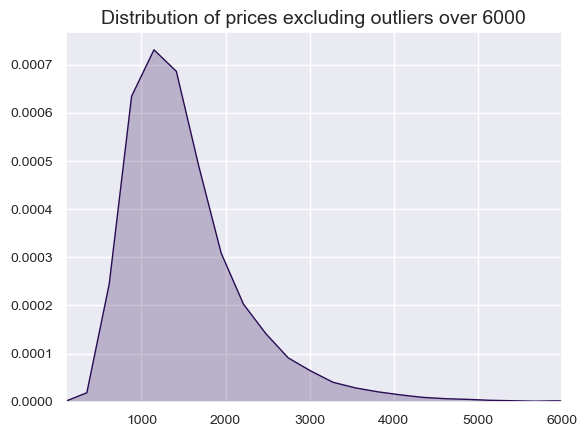

In [41]:
#Checking the distribution of prices in the dataset
plot = sns.kdeplot(data = apartments,
            x = 'Price',fill=True)
plot.set(xlim=(min(apartments['Price']),6000))
plot.set_title("Distribution of prices excluding outliers over 6000")
plot.set_xlabel("")
plot.set_ylabel("")

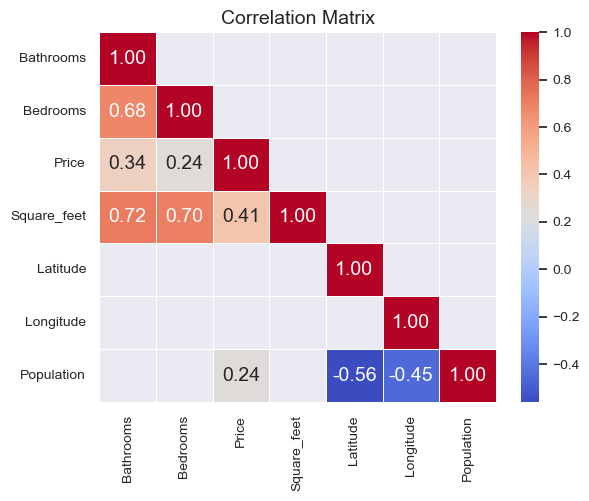

In [44]:
#Creating a correlation matrix, removing double entries to receive a lower triangular matrix
from pandas.plotting import scatter_matrix
correlation_matrix = apartments.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))
masked_correlation_matrix = correlation_matrix.mask(mask).where(abs(correlation_matrix) > 0.2) #setting a limit so to not display irrelevant correlations
np.fill_diagonal(masked_correlation_matrix.values, 1)
sns.heatmap(masked_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


array([[<AxesSubplot:xlabel='Price', ylabel='Price'>,
        <AxesSubplot:xlabel='Square_feet', ylabel='Price'>,
        <AxesSubplot:xlabel='Population', ylabel='Price'>],
       [<AxesSubplot:xlabel='Price', ylabel='Square_feet'>,
        <AxesSubplot:xlabel='Square_feet', ylabel='Square_feet'>,
        <AxesSubplot:xlabel='Population', ylabel='Square_feet'>],
       [<AxesSubplot:xlabel='Price', ylabel='Population'>,
        <AxesSubplot:xlabel='Square_feet', ylabel='Population'>,
        <AxesSubplot:xlabel='Population', ylabel='Population'>]],
      dtype=object)

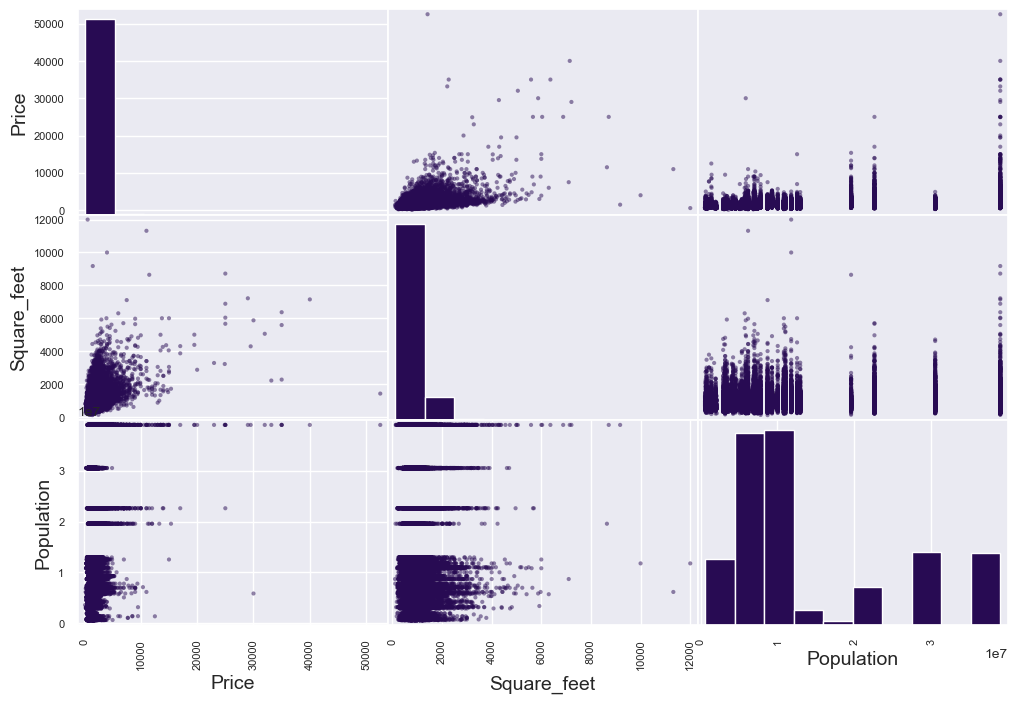

In [45]:
scatter_matrix(apartments[['Price','Square_feet','Population']],figsize=(12,8))

### Preparing data for machine learning

#### Data cleaning

In [46]:
#Confirming the amount of null values is 0
assert apartments.isnull().sum().sum() == 0, "There are some missing values in the dataframe."

#### Handling text and categorical data

In [47]:
# Extracting all values from Amenities column and making separate 1/0 columns for each amenity separately
all_amenities = set()
apartments['Amenities'].dropna().apply(lambda x: all_amenities.update(x.split(',')))
#apartments_test['Amenities'].dropna().apply(lambda x: all_amenities.update(x.split(',')))
for amenity in all_amenities:
    apartments[amenity] = apartments['Amenities'].apply(lambda x: 1 if amenity in x.split(',') else 0)

In [48]:
# Separating data on pets to 1/0 encoding
all_pets = set()
apartments['Pets_allowed'].dropna().apply(lambda x: all_pets.update(x.split(',')))
for pet in all_pets:
    apartments[pet] = apartments['Pets_allowed'].apply(lambda x: 1 if pet in x.split(',') else 0)


In [49]:
#Dropping unnecessary columns and renaming some new ones for clarity
apartments.drop(columns = ['Pets_allowed','Amenities','State_y','Unknown'],inplace=True)
apartments.rename({"None":"No amenities","Dogs":"Dogs_allowed","Cats":"Cats_allowed"}, axis=1, inplace=True)


In [50]:
# Transforming Fee from yes/no to 1/0
apartments['Fee'] = apartments['Fee'].map({"Yes":1, "No":0})


In [51]:
#One hot encoding for States and regions
apartments_cat = apartments.select_dtypes(object)
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
apartments_cat_1hot = cat_encoder.fit_transform(apartments_cat)
#converting results to a dataframe
apartments_cat_1hot_df = pd.DataFrame(apartments_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(apartments_cat.columns))
# adding to the original data frame
apartments = pd.concat([apartments, apartments_cat_1hot_df], axis=1)

In [53]:
apartments.drop(columns=['Region','Division'],inplace = True)

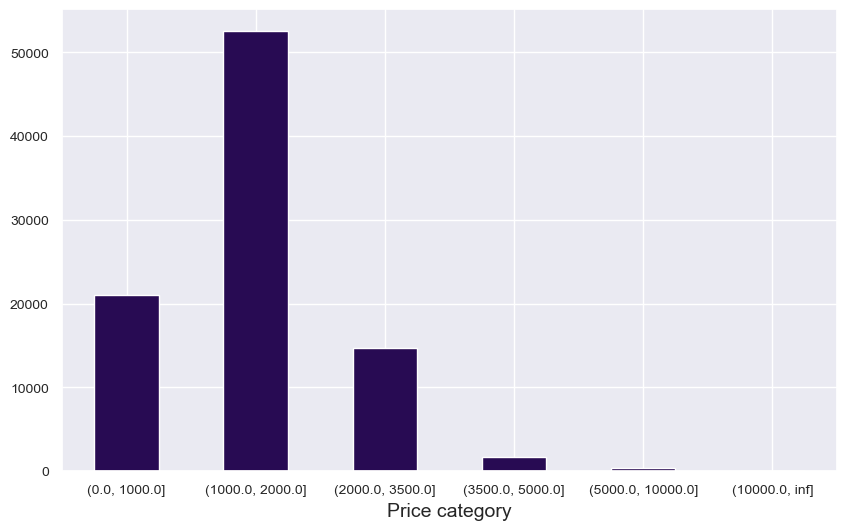

In [54]:
#Grouping size categories so the division can be used to take the stratified sample
bins = [0,1000,2000,3500,5000,10000,np.inf]
apartments['Price category'] = pd.cut(apartments['Price'],
                                      bins = bins
                                      )
apartments["Price category"].value_counts().sort_index().plot.bar(rot = 0, grid=True,figsize=(10,6))
plt.xlabel("Price category")
plt.show()

In [55]:
apartments.head(1)

,Bathrooms,Bedrooms,Fee,Price,Square_feet,Latitude,Longitude,Population,Cable or Satellite,Washer Dryer,...,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central,Region_Midwest,Region_Northeast,Region_South,Region_West,Price category
0,1.0,1.0,0,2195.0,542.0,33.852,-118.3759,38965193.0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(2000.0, 3500.0]"


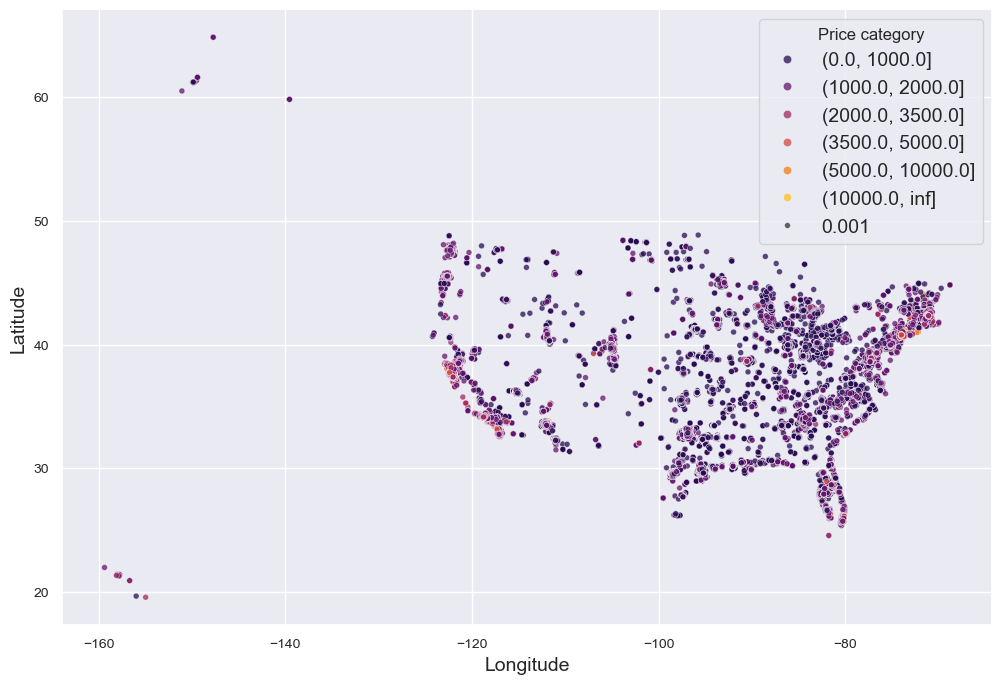

In [56]:
# plotting a scatter plot to check if there is any visible relation between localisation and the houses' size 
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue='Price category',
    data=apartments,
    alpha=0.75,
    size=0.001,
    legend = 'brief',
palette='inferno')


#### Feature scaling

#### Normalisation

In [57]:
apartments_to_normalize = apartments.drop(columns=['Price','Price category'])

In [58]:
apartments_to_normalize.head()

,Bathrooms,Bedrooms,Fee,Square_feet,Latitude,Longitude,Population,Cable or Satellite,Washer Dryer,Wood Floors,...,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central,Region_Midwest,Region_Northeast,Region_South,Region_West
0,1.0,1.0,0,542.0,33.8520,-118.3759,38965193.0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.5,3.0,0,1500.0,37.0867,-76.4941,8715698.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,3.0,0,1650.0,35.8230,-78.6438,10835491.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,2.0,0,820.0,38.3622,-121.9712,38965193.0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0,624.0,35.1038,-106.6110,2114371.0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
#In case transformation does not require any training, sklearn can be used to transform a feature like in the example
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log,inverse_func=np.exp)
log_population = log_transformer.transform(apartments_to_normalize[['Population']])

In [60]:
from sklearn.preprocessing import StandardScaler
apartments_num = apartments_to_normalize.select_dtypes(include='number')
#when scaling sparse matrix without transforming  into dense one, subtracting mean during the standardization might be skipped, because otherwise it would thwart the matrix's sparsity
#Here I choose mixed approach to standardization, meaning treating separately sparse and dense part of the matrix
dense_columns,sparse_columns = (apartments_num.columns[apartments_num.nunique() > 2],
    apartments_num.columns[apartments_num.nunique() == 2])
apartments_num_std_scaled = apartments_num.copy()
sparse_scaler = StandardScaler(with_mean=False)
apartments_num_std_scaled[sparse_columns] = sparse_scaler.fit_transform(apartments_num[sparse_columns])

dense_scaler = StandardScaler(with_mean=True)
apartments_num_std_scaled[dense_columns] = dense_scaler.fit_transform(apartments_num[dense_columns])

In [61]:
apartments_num_std_scaled[['Price','Price category']] = apartments[['Price','Price category']]

## Create a Test Set

#### Stratified shuffle split

In [62]:
# Splitting the data to train and test
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(
    apartments_num_std_scaled,test_size=0.2,random_state=42,stratify = apartments['Price category']
)
#Comparison of % of values in original dataset and the stratified sample
(train_set['Price category'].value_counts()/len(train_set),
 apartments['Price category'].value_counts()/len(apartments))

(Price category
 (1000.0, 2000.0]     0.579696
 (0.0, 1000.0]        0.232728
 (2000.0, 3500.0]     0.163020
 (3500.0, 5000.0]     0.019327
 (5000.0, 10000.0]    0.004442
 (10000.0, inf]       0.000786
 Name: count, dtype: float64,
 Price category
 (1000.0, 2000.0]     0.579693
 (0.0, 1000.0]        0.232734
 (2000.0, 3500.0]     0.163017
 (3500.0, 5000.0]     0.019325
 (5000.0, 10000.0]    0.004448
 (10000.0, inf]       0.000784
 Name: count, dtype: float64)

In [63]:
#Dropping price category as it won't be useful anymore
train_set_labels = train_set['Price'].copy()
test_set_labels = test_set['Price'].copy()
train_set.drop(columns = ["Price category","Price"],inplace = True)
test_set.drop(columns = ["Price category","Price"],inplace = True)

#### Training and validating the model

In [64]:
#Testing if all values in the train set are numerical
assert all(train_set.dtypes.apply(lambda x: x.kind in 'iuf')), "There are still some features that are not numerical"

#####  1.Linear regression

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lin_reg = LinearRegression()
lin_reg.fit(train_set, train_set_labels)
apartments_predictions_lr = lin_reg.predict(train_set)
lin_rmse = mean_squared_error(train_set_labels, apartments_predictions_lr,squared=False)
interquartile_range = np.percentile(train_set_labels,75)-np.percentile(train_set_labels,25)
print(f"RMSE of linear regression model: {lin_rmse}, for the dataset of: \n{train_set_labels.describe()}")

RMSE of linear regression model: 668.298771673289, for the dataset of: 
count    72488.000000
mean      1550.862418
std        899.919476
min        100.000000
25%       1030.000000
50%       1375.000000
75%       1821.000000
max      52500.000000
Name: Price, dtype: float64


In [75]:
if api_key is not None:
    interpretation_lr = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f"Interpret the results of the model: {lin_reg},RMSE: {lin_rmse}, for the dataset of: \n{train_set_labels.describe()}"}]
                                                    )
    print(interpretation_lr.choices[0].message.content)

The model LinearRegression has a Root Mean Squared Error (RMSE) of 668.30. This means that, on average, the model's predictions are off by approximately $668.30 from the actual prices in the dataset. 

Given that the mean price in the dataset is $1550.86, an RMSE of 668.30 suggests that the model's predictions are not very accurate. The RMSE is around 43% of the mean price, which indicates a relatively high level of error in the model's predictions.

It is important to note that the dataset has a wide range of prices, from $100 to $52,500, with a standard deviation of $899.92. This variability in prices may be contributing to the high RMSE of the model.

Overall, the model's performance may not be satisfactory for accurately predicting prices in this dataset, and further analysis or model improvements may be needed to achieve better results.


In [76]:
# Showing directly some predictions compared to labels
pd.DataFrame({"Predictions":apartments_predictions_lr[:5].round(2),"Labels": train_set_labels[:5].round(2)})

,Predictions,Labels
75124,1153.72,967.0
67562,1277.81,1350.0
81939,1677.47,2230.0
46690,2488.91,2345.0
4545,379.62,400.0


##### 2. Decision Tree Regressor

In [77]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_set, train_set_labels)

DecisionTreeRegressor(random_state=42)

In [78]:
apartments_predictions_dt = tree_reg.predict(train_set)
dt_rmse = mean_squared_error(train_set_labels, apartments_predictions_dt,squared=False)
print(f'Decision tree RMSE: {dt_rmse}')

Decision tree RMSE: 36.52052539968349


In [80]:
# Using cross validation to assess the decision tree model more precisely as the result of 36,5 is suspicious and it might have been overfitted.

#The cross validation function in sklearn expects utility function instead of the cost function, so "-" has to be added to receive RMSE scores in this case
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(
    tree_reg,train_set,train_set_labels,scoring = "neg_root_mean_squared_error", cv = 10
)
pd.Series(tree_rmses).describe()
print(
    f"model: {tree_reg},\nRMSE: {dt_rmse}, \nCross validation results: {tree_rmses}."
)

model: DecisionTreeRegressor(random_state=42),
RMSE: 36.52052539968349, 
Cross validation results: [558.40523797 527.86304916 498.67187001 458.21393272 455.66836717
 529.02796572 525.91717166 763.85189909 662.41142021 491.92144466].


In [81]:
if api_key is not None:
    interpretation_dt = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f" model: {tree_reg},RMSE: {dt_rmse}, Cross validation results: {tree_rmses}. Interpret the results  for the dataset of: \n{train_set_labels.describe()}"}]
                                                    )
    print(interpretation_dt.choices[0].message.content)

The DecisionTreeRegressor model with a random state of 42 has a root mean squared error (RMSE) of 36.52. This means that the model's predictions are off by an average of 36.52 units from the actual values.

The cross-validation results show the performance of the model on 10 different subsets of the data. The results range from 455.67 to 763.85, indicating some variability in the model's performance. However, the RMSE of 36.52 is relatively low compared to the range of prices in the dataset, which go from 100 to 52500.

Overall, the model seems to be performing reasonably well in terms of predicting the prices of items in the dataset. The RMSE of 36.52 is relatively small compared to the range of prices, indicating that the model is making accurate predictions. However, it is important to note that there is still some variability in the model's performance, as seen in the cross-validation results.


#### 3. Random forest regressor

In [82]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state =42)
forest_rmses = -cross_val_score(forest_reg,train_set,train_set_labels,scoring = "neg_root_mean_squared_error", cv = 10)
pd.Series(forest_rmses).describe()

count     10.000000
mean     414.243065
std      109.576963
min      329.756350
25%      359.783021
50%      368.233161
75%      427.664646
max      688.559076
dtype: float64

In [83]:
if api_key is not None:
    interpretation_rf = client.chat.completions.create(model = model,messages = [
    {"role":role,
     "content" : f" model: {forest_reg},RMSE: {forest_rmses}, Cross validation results: {pd.Series(forest_rmses).describe()}. Interpret the results  for the dataset of: \n{train_set_labels.describe()}"}])
    print(interpretation_rf.choices[0].message.content)


The RandomForestRegressor model was used to predict the Price of a dataset with a mean value of 1550.86. The RMSE values from the cross-validation results range from 329.76 to 688.56, with a mean RMSE of 414.24. 

Based on the results, we can see that the model tends to have a relatively high level of error in predicting the Price values. The model's performance can be considered moderate, as the RMSE values are relatively close to the mean Price value of the dataset. However, there is room for improvement in reducing the prediction errors to better capture the variability in the actual Price values.


#### Tuning the model (going with model 3) - with random search method

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
param_dist = {
    'n_estimators': np.arange(50, 301, 50),  # number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # features taken into consideration
    'max_depth': [None, 10, 20, 30, 40, 50],  # max trees depth
    'min_samples_split': [2, 5, 10],  # min samples to take
    'min_samples_leaf': [1, 2, 4],  # min samples in the leaves
    'bootstrap': [True, False]
}

forest_reg = RandomForestRegressor(random_state=42)

# random searchin with 10-fold cross-validation
random_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=10,  # number of folds
    verbose=2,  # level of information taken into account
    random_state=42,
    n_jobs=-1  # using all cpu cores
)
random_search.fit(train_set, train_set_labels)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [85]:
best_params = random_search.best_params_

best_rmse = -random_search.best_score_

best_forest_model = random_search.best_estimator_

importances = best_forest_model.feature_importances_

indices = importances.argsort()[::-1]

print("Feature ranking:")

for i in range(len(importances)):
    print(f"{apartments_num_std_scaled.columns[indices[i]]}: {importances[indices[i]]:.4f}")

final_predictions = best_forest_model.predict(train_set)
final_rmse = mean_squared_error(train_set_labels, final_predictions, squared=False)
print("Final RMSE on full data: ", final_rmse)

Feature ranking:
Square_feet: 0.1738
Longitude: 0.1672
Latitude: 0.1398
Bathrooms: 0.1205
Population: 0.0867
Division_Pacific: 0.0542
Bedrooms: 0.0502
Region_Northeast: 0.0165
Region_West: 0.0136
Region_South: 0.0130
Division_New England: 0.0093
Region_Midwest: 0.0091
Pool: 0.0084
Gym: 0.0084
Division_Middle Atlantic: 0.0077
Parking: 0.0071
Patio/Deck: 0.0069
Elevator: 0.0066
Washer Dryer: 0.0057
Playground: 0.0054
AC: 0.0051
Dishwasher: 0.0049
Refrigerator: 0.0046
Division_West North Central: 0.0046
Fireplace: 0.0046
Doorman: 0.0045
Tennis: 0.0045
Wood Floors: 0.0045
Dogs_allowed: 0.0045
Internet Access: 0.0044
Storage: 0.0043
Clubhouse: 0.0040
Cats_allowed: 0.0040
Division_West South Central: 0.0037
Gated: 0.0037
Division_Mountain: 0.0036
TV: 0.0035
Cable or Satellite: 0.0034
Division_South Atlantic: 0.0034
Division_East North Central: 0.0024
View: 0.0017
Hot Tub: 0.0017
Basketball: 0.0014
Garbage Disposal: 0.0013
Division_East South Central: 0.0012
Fee: 0.0004
Alarm: 0.0003
Luxury: 

### Testing the model on the test data

In [86]:
Y_test,X_test = (test_set_labels.copy(),
                 test_set.copy())
final_predictions_test = best_forest_model.predict(X_test)
final_test_rmse = mean_squared_error(Y_test,final_predictions_test,squared = False)
print(f" Final test RMSE: {final_test_rmse}")

 Final test RMSE: 538.6463671915066


In [87]:
#Calculating the confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions_test - Y_test) ** 2
confidence_interval = np.sqrt (stats.t.interval(
    confidence, len(squared_errors)-1,loc = squared_errors.mean(),
    scale  = stats.sem(squared_errors)
)
)

Text(0.5, 0, '')

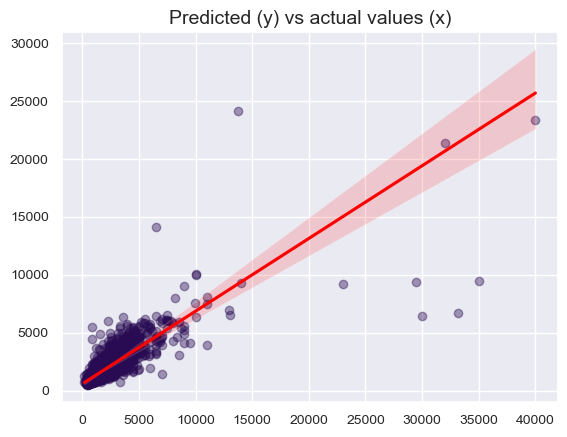

In [88]:
model_effectivness_plot = sns.regplot(
    y = final_predictions_test,
    x = Y_test,
    scatter_kws= {"alpha":0.4},
    line_kws={'color': 'red'},
)
model_effectivness_plot.set_title("Predicted (y) vs actual values (x)")
model_effectivness_plot.set_xlabel("")

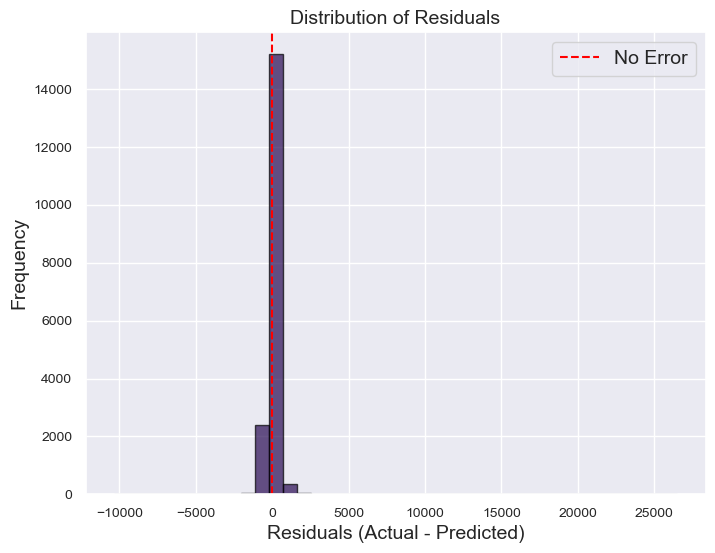

In [89]:
# Testing if errors have a normal distribution and if there are some systematic 
residuals = Y_test - final_predictions_test

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=40, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.legend()
plt.grid(True)
plt.show()

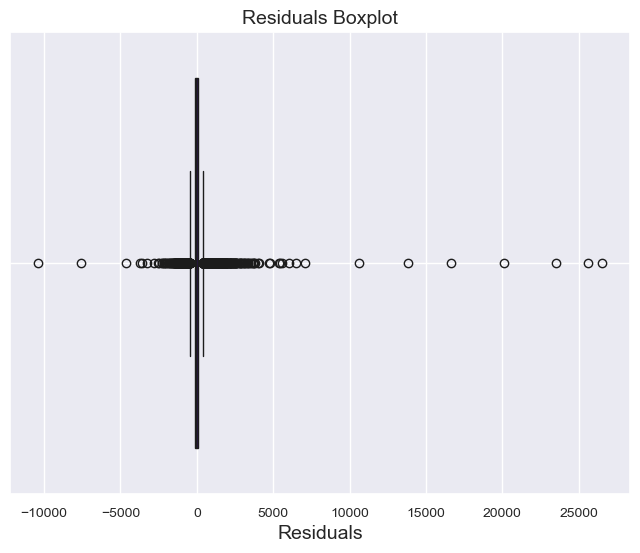

In [90]:
import seaborn as sns

# Boxplot of errors
plt.figure(figsize=(8, 6))
sns.boxplot(residuals, orient="h")
plt.title("Residuals Boxplot")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()


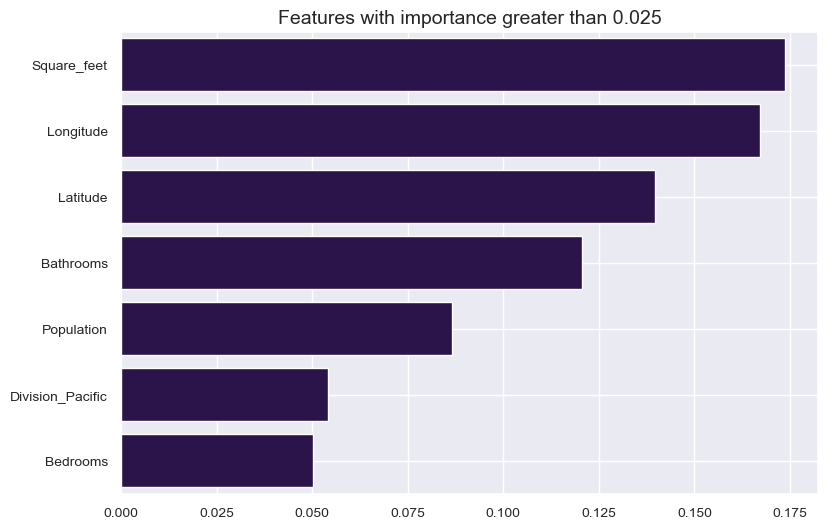

In [101]:
import pandas as pd

# Fetching features' importance
feature_importances = best_forest_model.feature_importances_
features = X_test.columns

# creating df with features
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plotting importance scores for the most import ones
plt.figure(figsize=(9, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df[importance_df['Importance']>0.025])
plt.title("Features with importance greater than 0.025")
plt.ylabel("")
plt.xlabel("")
plt.grid(True)
plt.show()


In [102]:
if api_key is not None:
    interpretation = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f" Interpret the results of the final test of the Model: random forest regressor. Results of final test on test_data: Final test RMSE: {final_test_rmse},confidence interval for RMSE: {confidence_interval},final predictions: {final_predictions_test}. Test data: {test_set_labels}"}]                                                )
    print(interpretation.choices[0].message.content)

The final test results of the random forest regressor model indicate that the Root Mean Square Error (RMSE) on the test data is 538.65. The confidence interval for the RMSE is between 394.47 and 651.67. The final predictions made by the model are also provided, which range from 1421.80 to 972.68.

Comparing the predictions with the actual test data, it seems that the model is making reasonably accurate predictions. However, further analysis may be needed to determine the overall performance of the model and identify any areas for improvement.
